<a href="https://colab.research.google.com/github/SEOYUNJE/Lung-Image-Analysis/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [24]:
import os
from glob import glob

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

## Road and Read Data

In [3]:
!pip install -q opendatasets
import opendatasets as od
# Covid19
od.download('https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis')
# Pneumonia
od.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')
# Tuberculosis
od.download('https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset')
# NIH Datasets(8 Lung Diseases & No Finding)
od.download('https://www.kaggle.com/datasets/nih-chest-xrays/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis


100%|██████████| 1.74G/1.74G [01:23<00:00, 22.4MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [01:42<00:00, 23.9MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset


100%|██████████| 663M/663M [00:26<00:00, 26.4MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data


100%|██████████| 42.0G/42.0G [33:31<00:00, 22.4MB/s]


#### Loading NIH Datasets(8 Lung Diseases & No Finding)

If you want to see EDA for this dataset, Click below notebook

-> https://www.kaggle.com/code/seoyunje/nih-chest-x-ray-eda-baseline-starter

📌 All Images Size are `1024x1024`

📌 Image format: `Png`

In [4]:
df = pd.read_csv('/content/data/Data_Entry_2017.csv')
df = df.drop(columns='Unnamed: 11')
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [5]:
## Make Image Path

%%time
tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','images', '*.png'))}

df['path'] = df['Image Index'].map(tmp)

CPU times: user 703 ms, sys: 61.8 ms, total: 765 ms
Wall time: 1.04 s


In [6]:
## There are Multi Class in datasets
## But I decide to use only Distinct Diseases, So I don't use include '|'

df = df[~df['Finding Labels'].str.contains('\|')]

#### Loading Pneumonia

📌 Average of Width: `1200`

📌 Average of Height: `825`

📌 Image Format: `Jpeg`

In [7]:
df_pneumonia = pd.DataFrame()
df_pneumonia['Image Index'] = os.listdir('/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
df_pneumonia['Finding Labels'] = 'Pneumonia'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','train','*','*.jpeg'))}
df_pneumonia['path'] = df_pneumonia['Image Index'].map(tmp)

df = pd.concat([df, df_pneumonia])
df = df.reset_index(drop=True)

#### Loading Tuberculosis

📌 Average of Width: `512`

📌 Average of Height: `512`

📌 Image Format: `png`

In [8]:
df_tuberculosis = pd.DataFrame()
df_tuberculosis['Image Index'] = os.listdir('/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/')
df_tuberculosis['Finding Labels'] = 'Tuberculosis'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','*','*.png'))}
df_tuberculosis['path'] = df_tuberculosis['Image Index'].map(tmp)

df = pd.concat([df, df_tuberculosis])
df = df.reset_index(drop=True)

#### Loading Covid-19

📌 Average of Width: `1200`

📌 Average of Height: `825`

📌 Image Format: `jpg`

In [9]:
train_covid = pd.DataFrame()
train_covid['Image Index'] = os.listdir('/content/chest-xray-pneumoniacovid19tuberculosis/train/COVID19/')
test_covid = pd.DataFrame()
test_covid['Image Index'] = os.listdir('/content/chest-xray-pneumoniacovid19tuberculosis/test/COVID19/')
df_covid = pd.concat([train_covid, test_covid])
df_covid['Finding Labels'] = 'Covid'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','*','*.jpg'))}
df_covid['path'] = df_covid['Image Index'].map(tmp)

df = pd.concat([df, df_covid])
df = df.reset_index(drop=True)
df['Label'] = df['Finding Labels'].copy()
df = df[['Image Index','Finding Labels', 'path', 'Label']]

In [10]:
## In this time, I did use StratifiedKFold
## But, We can use GroupKFold with making new columns 'patient id'

In [11]:
## For avoding Class Imbalance, For Speeding up
## I just select 500images for each label

df_1 = pd.concat([df[df['Label'] == 'Edema'].sample(500, random_state=42)])
df_2 = pd.concat([df[df['Label'] == 'No Finding'].sample(500, random_state=42)])
df_3 = pd.concat([df[df['Label'] == 'Pneumonia'].sample(500, random_state=42)])
df_4 = pd.concat([df[df['Label'] == 'Tuberculosis'].sample(500, random_state=42)])
df_5 = pd.concat([df[df['Label'] == 'Cardiomegaly'].sample(500, random_state=42)])
df_6 = pd.concat([df[df['Label'] == 'Emphysema'].sample(500, random_state=42)])
df_7 = pd.concat([df[df['Label'] == 'Covid'].sample(500, random_state=42)])
df_8 = pd.concat([df[df['Label'] == 'Effusion'].sample(500, random_state=42)])
df_9 = pd.concat([df[df['Label'] == 'Atelectasis'].sample(500, random_state=42)])


df = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9])
df = df.reset_index(drop=True)

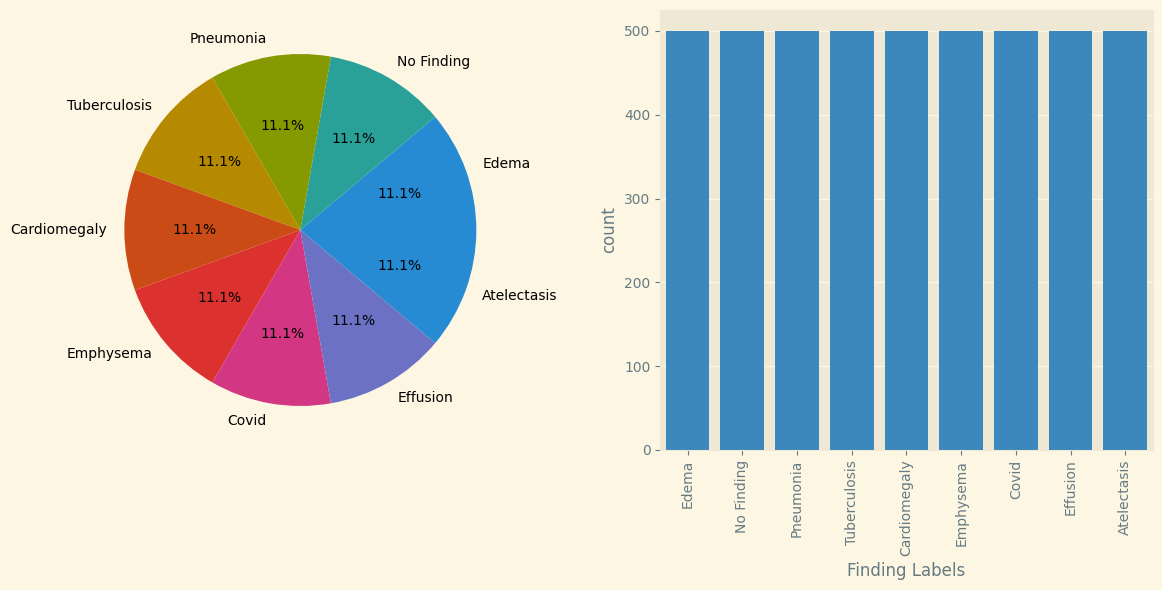

In [23]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Train & Test Split**

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [16]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 0.9,0.1/8).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 0.9,0.1/8).astype('float32')
TARGET = df_train.columns[-9:].tolist()

In [19]:
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Cardiomegaly',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

## Build DataGenerator

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2

In [21]:
class DataGenerator(Dataset):
    def __init__(self, data,augment1=False, preprocess=None):
        super().__init__()
        self.data = data
        self.augment1 = augment1
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        X, y = self.__data_generation(index)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X: self.__augment1(X)
        return X, y

    def __data_generation(self, index):

        X = np.zeros((256,256,3), dtype='float32')
        y = np.zeros((len(TARGET)), dtype='float32')

        row = self.data.iloc[index]
        path = row['path']
        img = Image.open(path).convert('L')
        img = img.resize((256,256), Image.Resampling.LANCZOS) # DownSampling
        img = np.array(img) # PIL Object -> np.array(uint8)
        img = self.clahe.apply(img)
        img = np.expand_dims(img, axis=-1)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # FillNaN
        m = np.nanmean(img)
        img = np.nan_to_num(img, nan=m)

        X = img
        y = row[TARGET]

        return torch.from_numpy(X).permute(2,0,1), torch.tensor(y, dtype=torch.float32)

    def __augment1(self, img):

        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            ToTensorV2()
        ])

        img = composition(image=img)['image']
        return img

In [25]:
train_gen = DataGenerator(df_train)
train_loader = DataLoader(
        train_gen,
        batch_size = 16,
        shuffle=True,
        pin_memory=False,
        drop_last=False,
        num_workers = 2,
    )

<ipython-input-21-70d99a858854>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.from_numpy(X).permute(2,0,1), torch.tensor(y, dtype=torch.float32)
<ipython-input-21-70d99a858854>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.from_numpy(X).permute(2,0,1), torch.tensor(y, dtype=torch.float32)
<ipython-input-21-70d99a858854>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.from_numpy(X).per

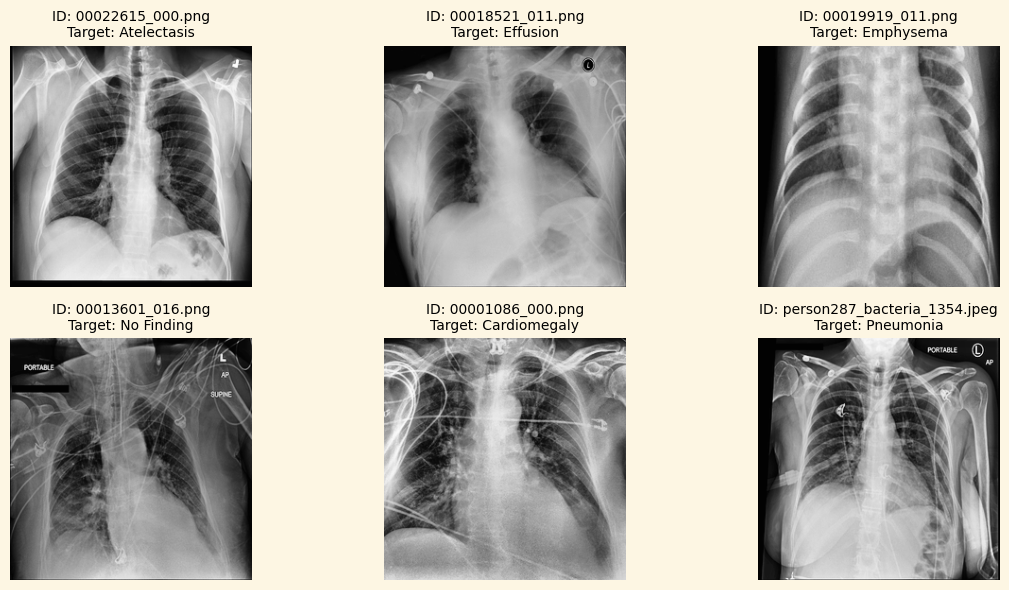

In [26]:
ROWS= 2; COLS=3; BATCHES=1

for i, (x,y) in enumerate(train_loader):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k].permute(1,2,0).cpu().numpy()
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break